# Recurrent Neural Networks

Recurrent Neural Networks (RNNs) represent a powerful class of neural networks specifically designed to handle sequential data and variable-length sequences. Unlike traditional feedforward neural networks, which process each input independently, RNNs have connections that form directed cycles, allowing them to exhibit dynamic temporal behavior.

At its core, an RNN architecture includes recurrent connections that enable the network to persist information across time steps, making them particularly effective for tasks such as time series prediction, natural language processing, speech recognition, and more. This inherent ability to capture temporal dependencies makes RNNs well-suited for tasks where the input data's context and ordering are essential.

## Libraries

In [1]:
# !pip install torch

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
from google.colab import drive
from scipy.signal import resample
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report

## Utilities

Here, some utility functions are defined. In particular, `train` and `test` are the functions used to train and test models, respectively.

In [3]:
# Training function.
def train(epoch, model, loader, criterion, optimizer, device='cpu'):
    l = 0
    for data in tqdm(loader, desc=f'Epoch {epoch+1:03d}'):
        x = data[0].to(device)
        y = data[1].to(device)
        out = model(x)
        loss = criterion(out, y)
        l += loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return l

# Test function.
def test(model, loader, criterion, device='cpu'):
    l = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in loader:
            x = data[0].to(device)
            y = data[1].to(device)
            out = model(x)
            l += criterion(out, y)
            _, pred = torch.max(out.data, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            y_true += y.tolist()
            y_pred += pred.tolist()
    return l, correct / total, f1_score(y_true, y_pred, average='macro'), y_true, y_pred

The `CustomDataset` class encapsulates the functionality required to prepare custom data for training deep learning models in PyTorch. By implementing methods such as `__len__` and `__getitem__`, it conforms to the interface expected by PyTorch's `DataLoader`, which is used to iterate over batches of data during training or evaluation.

In [4]:
# Custom dataset, as we discussed in the first lecture (PyTorch Basics).
class CustomDataset(Dataset):

    # Stores the data.
    def __init__(self, x, y=None, transforms=None):
        super().__init__()
        self.x = x
        self.y = y
        self.transforms = transforms

    # Returns the length of the dataset.
    def __len__(self):
        return self.x.shape[0]

    # Returns a (x, y) pair from the dataset.
    def __getitem__(self, idx):
        x = self.x.iloc[idx, :]
        if self.transforms is not None:
            x = self.transforms(x)
        x = torch.tensor(x).float().unsqueeze(-1)
        y = torch.tensor([self.y.iloc[idx]]).type(torch.LongTensor).squeeze()
        return x, y

## Data

We will use the [MIT-BIH Arrhythmia](https://physionet.org/content/mitdb/1.0.0/) dataset, which can be downloaded from Kaggle [here](https://www.kaggle.com/datasets/shayanfazeli/heartbeat). This dataset contain ambulatory ECG recordings and defines a multiclass classification problem.

To run the following cells, you should first download the dataset and then upload the two files, `mitbih_train.csv` and `mitbih_test.csv`, here on Google Colab. Otherwise, you can upload the files on Google Drive and access them by connecting Colab to Drive.

In [5]:
# Connect Google Drive.
drive.mount('/content/drive')

Mounted at /content/drive


Each sample of the dataset defines a univariate time-series composed of $187$ time-steps. The last column of each sample stores the specific class label.

In [6]:
# Read train and test data.
df_train = pd.read_csv('drive/MyDrive/mitbih_train.csv', header=None)
df_test = pd.read_csv('drive/MyDrive/mitbih_test.csv', header=None)

# Training dataframe.
df_train

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


The distribution of classes in our dataset is significantly imbalanced, highlighting a crucial consideration in model evaluation. Relying solely on accuracy as a metric may not provide an accurate reflection of the model's performance, as it could be disproportionately influenced by the majority class. To address this imbalance, we need to explore alternative evaluation metrics and strategies. Augmenting the minority classes is one viable approach to mitigate this issue, but others can be considered (e.g., using class weights in the evaluation of the loss function).

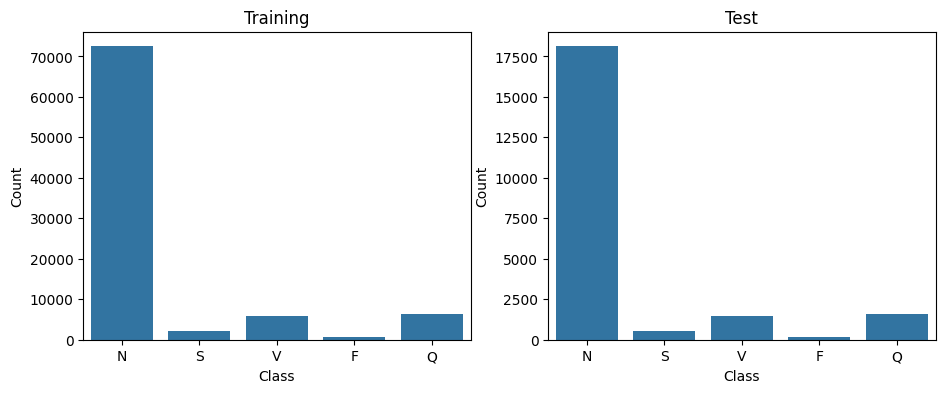

In [7]:
# From label index to label name.
labels_map = {
    0: 'N', # Normal
    1: 'S', # Fusion of paced and normal
    2: 'V', # Premature ventricular contraction
    3: 'F', # Atrial premature
    4: 'Q'  # Fusion of ventricular and normal
}

# Plot distributions.
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
sns.countplot(x=df_train[df_train.shape[1] - 1], ax=ax[0])
sns.countplot(x=df_test[df_test.shape[1] - 1], ax=ax[1])
ax[0].set_title('Training')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')
ax[0].set_xticks(list(labels_map.keys()))
ax[0].set_xticklabels(list(labels_map.values()))
ax[1].set_title('Test')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')
ax[1].set_xticks(list(labels_map.keys()))
ax[1].set_xticklabels(list(labels_map.values()))
plt.show()

The purpose of plotting sample data is to visually inspect the waveform patterns associated with different cardiac rhythms represented by the labels. This allows for a qualitative assessment of the data distribution and can aid in understanding the characteristics of each rhythm type.

Each subplot in the grid represents a random sample from the dataset, with the waveform plotted on the y-axis and the sample index on the x-axis. The title of each subplot indicates the corresponding cardiac rhythm type based on the label mapping, providing context for the displayed waveform.

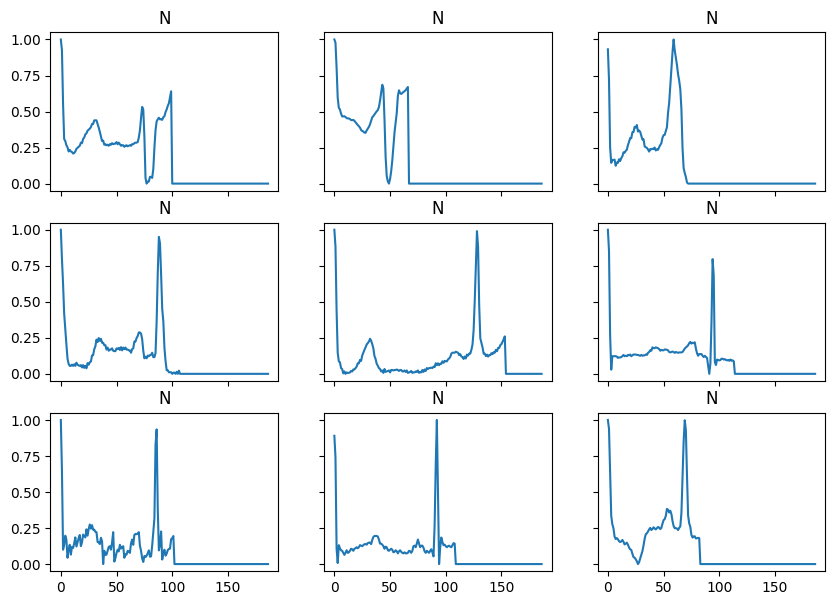

In [8]:
# Plot some data.
rows, cols = 3, 3
fig, ax = plt.subplots(rows, cols, figsize=(10, 7), sharex=True, sharey=True)
for r in range(rows):
    for c in range(cols):
        sample = df_train.sample(1).values.flatten()
        y = labels_map[sample[-1]]
        ax[r, c].plot(sample[:-1])
        ax[r, c].set_title(y)
plt.show()

### Data Preprocessing and Augmentation

This code cell defines three classes (`Stretch`, `Amplify`, and `Augment`) for randomly augmenting input signals. Each class implements a different signal augmentation technique:

- The `Stretch` class randomly stretches the input signal by resampling it to a new length. The stretching factor is randomly chosen within a certain range. The length of the stretched signal is either shorter or longer than the original signal, but then gets cropped to be of the same length of the original signal.

- The `Amplify` class randomly amplifies the input signal by applying a random scaling factor. The scaling factor is determined by a random value between $-0.5$ and $0.5$, which controls the degree of amplification.

- The `Augment` class combines multiple augmentation techniques specified in the `aug_list`. During the augmentation process, each augmentation technique in the list is randomly applied to the input signal with a $50\%$ probability.

In [9]:
# Randomly stretches the signal.
class Stretch:
    def __init__(self):
        pass

    def __call__(self, x):
        n = x.shape[0]
        l = int(n * (1 + (random.random() - 0.5) / 3))
        y = resample(x, l)
        if l < n:
            y_ = np.zeros(shape=(n,))
            y_[:l] = y
        else:
            y_ = y[:n]
        return y_

    def __repr__(self):
        return 'Stretch'

# Randomly amplifies the signal.
class Amplify:
    def __init__(self):
        pass

    def __call__(self, x):
        alpha = (random.random() - 0.5)
        factor = -alpha * x + (1 + alpha)
        return x * factor

    def __repr__(self):
        return 'Amplify'

# Randomly augments the input signal.
class Augment:
    def __init__(self, aug_list, verbose=False):
        self.aug_list = aug_list
        self.verbose = verbose

    def __call__(self, x):
        augs = ''
        for i, aug in enumerate(self.aug_list):
            if np.random.binomial(1, 0.5) == 1:
                x = aug(x)
                augs += f'{aug}, ' if i < len(self.aug_list) - 1 else f'{aug}'
        if not self.verbose:
            return x
        return x, augs

An instance of the `Augment` class is created, and signal augmentations are applied to sample data from the training dataset. The augmented samples are then plotted alongside the original samples to visualize the effects of the augmentation techniques.

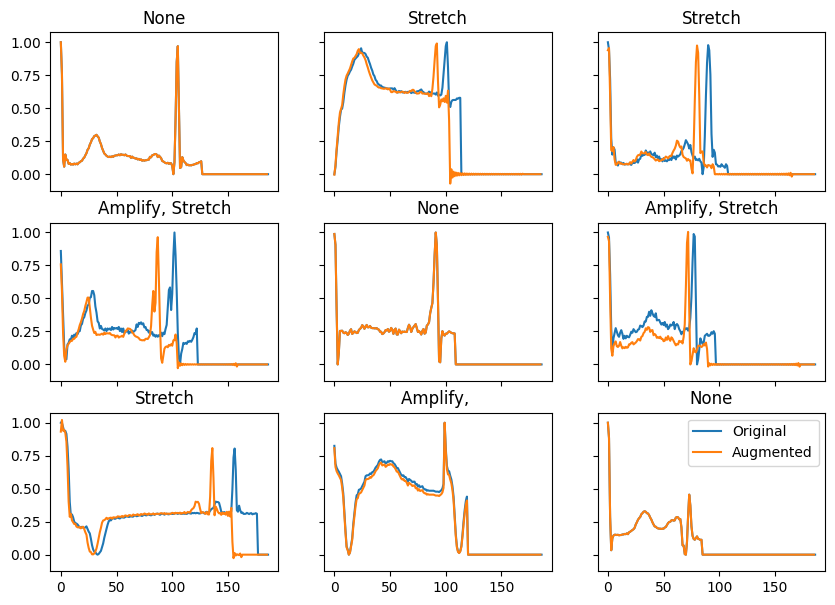

In [10]:
# New Augment object.
augment = Augment([Amplify(), Stretch()], True)

# Plot augmentations.
rows, cols = 3, 3
fig, ax = plt.subplots(rows, cols, figsize=(10, 7), sharex=True, sharey=True)
for r in range(rows):
    for c in range(cols):
        sample = df_train.sample(1).values.flatten()
        aug_sample, augs = augment(sample[:-1])
        y = labels_map[sample[-1]]
        ax[r, c].plot(sample[:-1])
        ax[r, c].plot(aug_sample[:-1])
        ax[r, c].set_title(augs if augs != '' else 'None')
plt.legend(['Original', 'Augmented'])
plt.show()

 The data processing pipeline is set up for training and testing a neural network model using PyTorch. This includes defining the batch size and creating `Dataset` plus `DataLoader` objects for both training and testing datasets.

In [11]:
# Batch size.
batch_size = 64

# New Augment object.
augment = Augment([Amplify(), Stretch()])

# Creating the Dataset objects.
train_dataset = CustomDataset(df_train.iloc[:, :-1], df_train.iloc[:, -1], transforms=augment)
test_dataset = CustomDataset(df_test.iloc[:, :-1], df_test.iloc[:, -1])

# Creating the DataLoader objects.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In order to feed the input data to an RNN model, we need each time-series to be tensors in $\mathbb{R}^{S \times H_{in}}$, where $S = 187$ represents the sequence length and $H_{in} = 1$ represents the input size. Indeed, our time-series consider one real value at each possible time-step. Thus, each batch of data will be a tensor in $\mathbb{R}^{N \times S \times H_{in}}$, where $N$ is the chosen batch size.

In [12]:
# Print the shape of a batch.
for x, y in train_loader:
    print(f'x: {x.shape}, y: {y.shape}')
    break

x: torch.Size([64, 187, 1]), y: torch.Size([64])


## Model Definition

First, we set up our system to utilize a GPU if available. Remember, every time you want to train of test a model, both the input data and the model must be on the same device. In general, `torch.tensor` objects and `nn.Module` objects can be moved to the proper device using `.to(device)`.

In [13]:
# Device configuration.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Then, we define a few key parameters:
- The input size $H_{in}$ (`input_size`).
- The hidden size $H_{cell}$ (`hidden_size`).
- The number of RNN layers (`num_layers`).
- The number of classes we're working with (`num_classes`).

In [14]:
# Model hyperparameters.
input_size = 1
hidden_size = 32
num_layers = 2
num_classes = 5

The following code cell implements the class used to define a Long Short-Term Memory (LSTM) model.

In particular, LSTM is a type of recurrent neural network architecture designed to overcome the limitations of traditional RNNs in capturing long-term dependencies in sequential data.

LSTMs contain a **cell state**, $c_t$, and a **hidden state**, $h_t$. The cell state is modified by proper mechanisms, known as **gates**, and acts as a form of long-term memory, facilitating the capture of temporal dependencies in the data. The hidden state, also known as the output state, captures the relevant information from the cell state and outputs it to the subsequent layers or the final output layer of the network. The hidden state encapsulates the network's understanding of the input sequence up to the current time step.

LSTMs utilize specialized gates to control the flow of information through the network. These gates include:
- **Forget Gate**. Determines which information from the previous cell state should be discarded or forgotten.
- **Input Gate**. Modulates the amount of new information to be added to the cell state.
- **Output Gate**. Regulates the information to be output from the current cell state.

In particular:

- The content of the input, forget and output gates can be computed as:

$$
i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} x_{t - 1} + b_{hi}) \\
f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} x_{t - 1} + b_{hf}) \\
o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} x_{t - 1} + b_{ho}) \\
$$

- An initial proposal for the new cell state can be compued as:

$$
\tilde{c}_t = \text{tanh}(W_{i\tilde{c}} x_t + b_{i\tilde{c}} + W_{h\tilde{c}} x_{t - 1} + b_{h\tilde{c}})
$$

- The cell state is updated taking into consideration $i_t$, $f_t$ and $\tilde{c}_t$. More specifically, the forget gate controls what to forget about $c_{t - 1}$, while the input gate controls what to consider from $\tilde{c}_t$.

$$
c_t = f_t \odot c_{t - 1} + i_t \odot \tilde{c}_{t}
$$

- Lastly, the hidden state can be computed considering the output gate, $o_t$ and the cell state, $c_t$:

$$
h_t = o_t \odot \text{tanh}(c_t)
$$

Here, The model architecture we consider consists of `num_layers` (namely, two) LSTM layers followed by a fully connected layer that produces the classification result.

The fully connected layer only considers the last output from the LSTM layers to compute the classification scores:

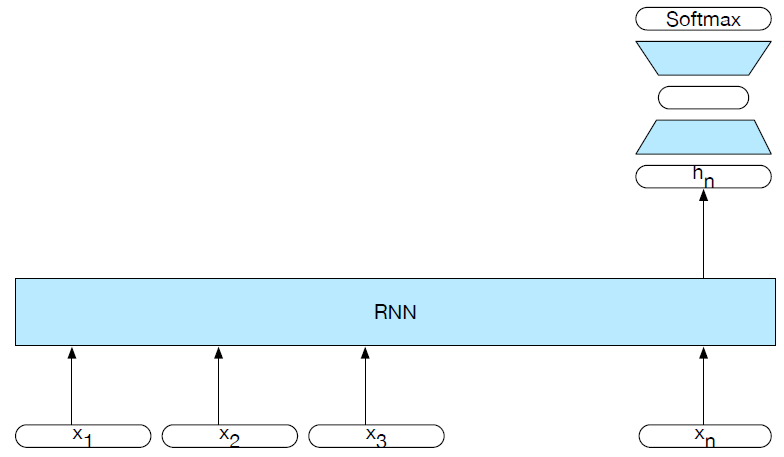

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))  # out: (batch size, seq length, hidden size)
        out = self.fc(out[:, -1, :]) # out: (batch size, num classes)
        return out

# New model.
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

## Training and Test

We define few other parameters:
- The duration of training (`num_epochs`).
- The pace at which our model learns (`learning_rate`).

In [16]:
# Training hyperparameters.
num_epochs = 10
learning_rate = 0.0001

We define the loss function using `nn.CrossEntropyLoss`, a suitable choice for multiclass classification tasks like ours. This function quantifies the disparity between the predicted class probabilities and the actual class labels.

Moving on to optimization, we employ the Adam optimizer, a popular choice for its adaptive learning rate properties.

We finally train and test the model for ten epochs. At the end of each epoch we print both the training and test loss, as well as the test accuracy and test F1-score.

In [17]:
# Loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and test.
for epoch in range(num_epochs):
    train_loss = train(epoch, model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, test_f1, y_true, y_pred = test(model, test_loader, criterion, device)
    print(f'Epoch {epoch+1:03d}: training loss {train_loss:.4f}, test loss {test_loss:.4f}, test acc {test_acc:.4f}, test f1 {test_f1:.4f}')

Epoch 001: 100%|██████████| 1369/1369 [01:35<00:00, 14.39it/s]


Epoch 001: training loss 1069.3953, test loss 227.4504, test acc 0.8276, test f1 0.1811


Epoch 002: 100%|██████████| 1369/1369 [01:38<00:00, 13.87it/s]


Epoch 002: training loss 899.2069, test loss 227.1748, test acc 0.8276, test f1 0.1811


Epoch 003: 100%|██████████| 1369/1369 [01:33<00:00, 14.59it/s]


Epoch 003: training loss 896.1603, test loss 225.1575, test acc 0.8276, test f1 0.1811


Epoch 004: 100%|██████████| 1369/1369 [01:24<00:00, 16.27it/s]


Epoch 004: training loss 872.1251, test loss 210.0717, test acc 0.8276, test f1 0.1811


Epoch 005: 100%|██████████| 1369/1369 [01:30<00:00, 15.07it/s]


Epoch 005: training loss 822.3733, test loss 202.5472, test acc 0.8276, test f1 0.1811


Epoch 006: 100%|██████████| 1369/1369 [01:13<00:00, 18.54it/s]


Epoch 006: training loss 808.3528, test loss 197.1135, test acc 0.8276, test f1 0.1811


Epoch 007: 100%|██████████| 1369/1369 [01:13<00:00, 18.63it/s]


Epoch 007: training loss 796.9513, test loss 193.9910, test acc 0.8276, test f1 0.1811


Epoch 008: 100%|██████████| 1369/1369 [01:13<00:00, 18.67it/s]


Epoch 008: training loss 809.3642, test loss 193.6179, test acc 0.8276, test f1 0.1811


Epoch 009: 100%|██████████| 1369/1369 [01:14<00:00, 18.26it/s]


Epoch 009: training loss 799.2958, test loss 196.5025, test acc 0.8276, test f1 0.1811


Epoch 010: 100%|██████████| 1369/1369 [01:12<00:00, 18.86it/s]


Epoch 010: training loss 791.3802, test loss 195.4708, test acc 0.8276, test f1 0.1811


Given the class imbalance in our training dataset, it's crucial to recognize that accuracy alone may not be the most suitable metric for evaluating our model's performance. The dataset exhibits varying class frequencies, leading to a situation where the majority class might dominate the accuracy metric, potentially masking the model's performance on minority classes. As a result, we need to complement accuracy with other metrics. In this case, we mainly focus on the macro F1-score.

Here, it is possible to notice how all samples belonging to all minority classes are miss-classified. This means that our model always outputs $0$.

In [18]:
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91     18118
           1       0.00      0.00      0.00       556
           2       0.00      0.00      0.00      1448
           3       0.00      0.00      0.00       162
           4       0.00      0.00      0.00      1608

    accuracy                           0.83     21892
   macro avg       0.17      0.20      0.18     21892
weighted avg       0.68      0.83      0.75     21892



In the following code cell, a particular strategy is employed to address the imbalanced nature of dataset during the training phase. To rectify the potential bias introduced by the disproportionate class distribution, the code leverages PyTorch's `WeightedRandomSampler`.

It begins by extracting the labels of the training dataset, forming a list of training targets. Subsequently, class weights are computed using the `compute_class_weight` function from scikit-learn, with the `'balanced'` option ensuring that weights are assigned inversely proportional to class frequencies. These weights are then applied to each individual image in the training set, creating a set of weights that mirrors the distribution of the classes.

The `WeightedRandomSampler` utilizes these weights to create a sampling strategy for the training dataset. By assigning higher probabilities to instances from minority classes, this sampler ensures that the model is exposed to a more balanced representation during training. This technique essentially emulates data augmentation for minority classes.

In [19]:
# List of training labels.
train_targets = list(df_train[df_train.shape[1] - 1])

# Computing class weights based on class frequency.
cls_weights = torch.from_numpy(compute_class_weight('balanced',
                                                    classes=np.unique(train_targets),
                                                    y=train_targets))

# Resulting array of weights.
weights = cls_weights[train_targets]

# Weighted random sampler. Used to consider copies of minority classes.
sampler = torch.utils.data.WeightedRandomSampler(weights,
                                                 len(train_targets),
                                                 replacement=True)

# Train loader.
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=batch_size)

Once the new training loader is computed, a new model is trained for ten epochs and its test performances are evaluated.

In [20]:
# New model.
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and test.
for epoch in range(num_epochs):
    train_loss = train(epoch, model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, test_f1, y_true, y_pred = test(model, test_loader, criterion, device)
    print(f'Epoch {epoch+1:03d}: training loss {train_loss:.4f}, test loss {test_loss:.4f}, test acc {test_acc:.4f}, test f1 {test_f1:.4f}')

Epoch 001: 100%|██████████| 1369/1369 [01:35<00:00, 14.32it/s]


Epoch 001: training loss 2201.4351, test loss 548.5988, test acc 0.0800, test f1 0.0634


Epoch 002: 100%|██████████| 1369/1369 [01:26<00:00, 15.81it/s]


Epoch 002: training loss 1886.1914, test loss 510.2562, test acc 0.3069, test f1 0.1972


Epoch 003: 100%|██████████| 1369/1369 [01:34<00:00, 14.46it/s]


Epoch 003: training loss 1757.6223, test loss 496.2713, test acc 0.3672, test f1 0.2327


Epoch 004: 100%|██████████| 1369/1369 [01:47<00:00, 12.77it/s]


Epoch 004: training loss 1742.8685, test loss 490.5275, test acc 0.3662, test f1 0.2361


Epoch 005: 100%|██████████| 1369/1369 [01:36<00:00, 14.24it/s]


Epoch 005: training loss 1713.5155, test loss 508.7764, test acc 0.3201, test f1 0.2190


Epoch 006: 100%|██████████| 1369/1369 [01:37<00:00, 14.04it/s]


Epoch 006: training loss 1695.3843, test loss 496.4974, test acc 0.2978, test f1 0.2124


Epoch 007: 100%|██████████| 1369/1369 [01:35<00:00, 14.34it/s]


Epoch 007: training loss 1689.3213, test loss 488.8855, test acc 0.3206, test f1 0.2221


Epoch 008: 100%|██████████| 1369/1369 [01:27<00:00, 15.56it/s]


Epoch 008: training loss 1688.9004, test loss 507.7215, test acc 0.3350, test f1 0.2296


Epoch 009: 100%|██████████| 1369/1369 [01:36<00:00, 14.14it/s]


Epoch 009: training loss 1686.4802, test loss 488.4962, test acc 0.2992, test f1 0.2153


Epoch 010: 100%|██████████| 1369/1369 [01:19<00:00, 17.17it/s]


Epoch 010: training loss 1986.3058, test loss 492.9639, test acc 0.3959, test f1 0.2236


Despite a drop in accuracy, our model is now able to correctly classify some of the samples belonging to minority classes. In general, these scores are not good, but this shows how one can use data augmentation to deal with unbalanced datasets.

In [21]:
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.93      0.37      0.53     18118
           1       0.01      0.05      0.02       556
           2       0.15      0.27      0.19      1448
           3       0.02      0.33      0.04       162
           4       0.21      0.92      0.34      1608

    accuracy                           0.40     21892
   macro avg       0.26      0.39      0.22     21892
weighted avg       0.79      0.40      0.48     21892

